# Analysis

In [1]:
import os
import json
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from util.utils import get_vocab_list

In [2]:
path = 'checkpoint'
model_names = ['base', 'base+gat', 'base+cap-pred', 'base+gat+cap-pred']

In [3]:
vocab_list = get_vocab_list('../data/vocab_list.txt')
ans_list = get_vocab_list('../data/answer_candidate.txt')
with open(os.path.join('../annot/index.pkl'), 'rb') as f:
    ans_index = pickle.load(f)

In [4]:
with open(os.path.join('../data/v2_OpenEnded_mscoco_val2014_questions.json')) as f:
    vqa_q = json.load(f)['questions']

In [5]:
with open(os.path.join('../data/v2_mscoco_val2014_annotations.json')) as f:
    vqa_a = json.load(f)['annotations']

In [6]:
# Load the predicted labels and scores
labels = {}
scores = {}

for model_name in model_names:
    with open(os.path.join(path, model_name, 'vqa', 'labels.pt'), 'rb') as f:
        labels[model_name] = torch.load(f)[:len(vqa_a)].numpy()
    with open(os.path.join(path, model_name, 'vqa', 'scores.pt'), 'rb') as f:
        scores[model_name] = torch.load(f)[:len(vqa_a)].numpy()

## Effectiveness among different answer types
We compare among three answer types base on the questions that BASE model predicts wrong.

In [7]:
def compare_ans_type(model_name):
    count = {'yes/no':[], 'number':[], 'other':[]}
    annot = []
    for i in range(1, 4):
        temp = np.logical_and(scores[model_name] > (i-1)/3, scores[model_name] < (i+1)/3)
        compare = np.logical_and(scores['base'] == 0, temp) # [model_name] gets score = i/3 and BASE model gets score = 0
        for ans_type in ans_index:
            v = sum(compare[ans_index[ans_type]])
            count[ans_type].append(v)
            annot.append(v)

    count['sum'] = []
    for i in range(3):
        s = 0
        for ans_type in ans_index: s += count[ans_type][i]
        count['sum'].append(s)

    count['label'] = [str(i) for i in range(1, 4)]
    count['label'][-1] = '>=3'

    df = pd.DataFrame(count)
    ax = df.plot(x="label", y=["yes/no","number","other"], kind="bar", figsize=(12, 10))
    for i, p in enumerate(ax.patches):
        ax.annotate(f'{p.get_height()}', (p.get_x() * 1.004, p.get_height()*1.007))
    plt.xticks(rotation=0)
    plt.xlabel('accepted by x annotators')
    plt.ylabel('amount of data')
    plt.ylim(0, 10500)
    plt.title(model_name)
    return ax

<AxesSubplot:title={'center':'base+gat'}, xlabel='accepted by x annotators', ylabel='amount of data'>

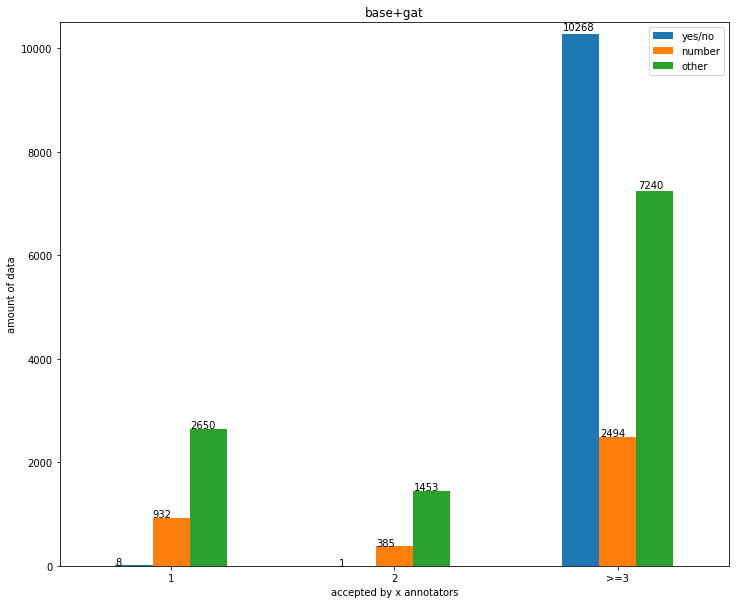

In [8]:
compare_ans_type('base+gat')

<AxesSubplot:title={'center':'base+cap-pred'}, xlabel='accepted by x annotators', ylabel='amount of data'>

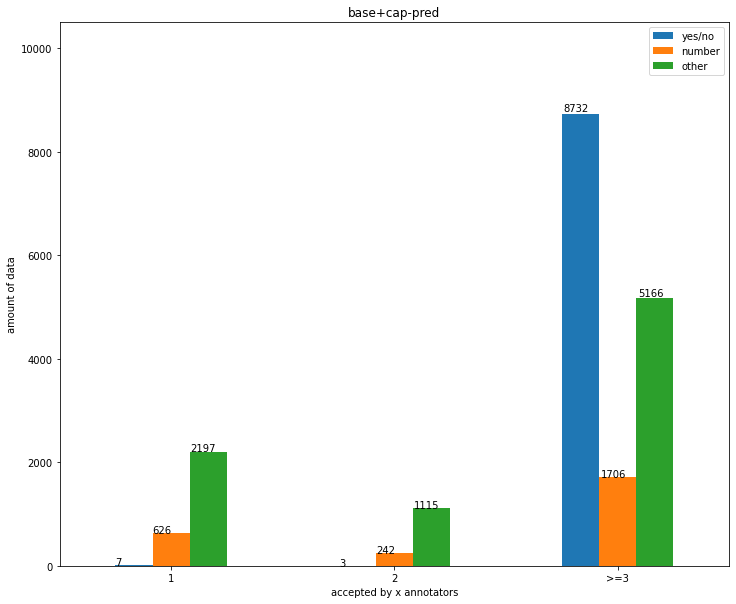

In [9]:
compare_ans_type('base+cap-pred')

## Effectiveness among different question types
Compare the accuracy for different question types.

In [10]:
question_type = {}
for i in tqdm(range(len(vqa_a))):
    temp = vqa_a[i]['question_type']
    if temp not in question_type: question_type[temp] = []
    question_type[temp].append(i)

100%|██████████| 214354/214354 [00:00<00:00, 756881.81it/s]


In [11]:
count = {'question_type': question_type.keys()}
for model_name in model_names:
    count[model_name] = []
    for q_type in tqdm(question_type):
        count[model_name].append(scores[model_name][question_type[q_type]].mean())

100%|██████████| 65/65 [00:00<00:00, 3246.91it/s]


In [12]:
def compare_question_type(model_name):
    compare = []
    for i in range(len(count['base'])):
        compare.append((count[model_name][i] - count['base'][i]) / count['base'][i] * 100)
    show_df = pd.DataFrame({
        'question_type': question_type.keys(),
        'base': count['base'],
        model_name: count[model_name],
        'compare': compare
    })
    show_df = show_df.sort_values(by=['compare'], ascending=False)

    f, ax = plt.subplots(figsize=(8, 14))
    sns.barplot(data=show_df, y='question_type', x='compare')
    for bar in ax.patches:
        if bar.get_width() > 0:
            bar.set_color('green')
        else:
            bar.set_color('red')
        h = bar.get_width()*1.01
        x = bar.get_y()+bar.get_height()*1.1/2
        if h < 0: h -= bar.get_height()*2.5
        ax.annotate(str(f'{bar.get_width():.1f}'), (h, x))
    plt.xticks(rotation=90)
    plt.ylabel('question type')
    plt.xlabel('effectiveness (%)')
    plt.title(model_name)
    ax.axvline(0, color='black')
    return ax

<AxesSubplot:title={'center':'base+gat'}, xlabel='effectiveness (%)', ylabel='question type'>

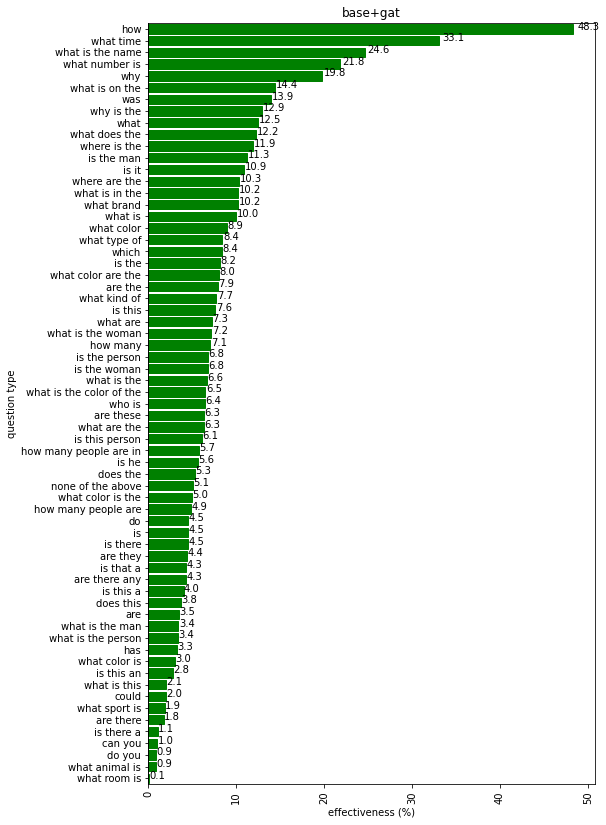

In [13]:
compare_question_type('base+gat')

<AxesSubplot:title={'center':'base+cap-pred'}, xlabel='effectiveness (%)', ylabel='question type'>

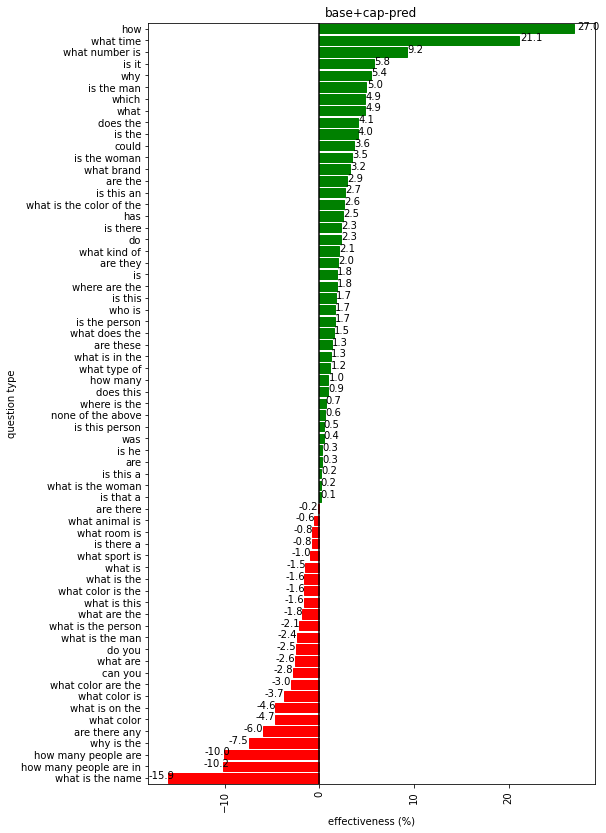

In [14]:
compare_question_type('base+cap-pred')